경로 :  [0, 862, 66, 918, 944, 922, 971, 426, 764, 679, 736, 958, 965, 964, 748, 172, 937, 892, 933, 981, 386, 304, 680, 397, 229, 176, 11, 781, 961, 401, 399, 924, 731, 18, 976, 868, 985, 914, 363, 795, 706, 794, 685, 948, 968, 888, 750, 717, 699, 802, 846, 901, 900, 866, 721, 949, 788, 432, 155, 137, 785, 682, 786, 104, 214, 474, 464, 242, 910, 44, 950, 784, 283, 157, 281, 814, 700, 962, 874, 970, 739, 373, 776, 333, 865, 905, 762, 738, 931, 712, 727, 816, 987, 982, 991, 873, 729, 54, 878, 822, 941, 118, 237, 707, 875, 810, 249, 761, 254, 882, 342, 279, 978, 824, 915, 806, 315, 295, 287, 9, 799, 416, 714, 955, 765, 953, 984, 787, 834, 837, 830, 880, 694, 187, 989, 803, 919, 870, 461, 395, 876, 326, 942, 411, 98, 783, 895, 916, 760, 726, 804, 198, 877, 887, 227, 891, 959, 872, 232, 290, 735, 768, 40, 963, 711, 368, 206, 850, 751, 926, 913, 960, 747, 906, 730, 722, 847, 681, 849, 840, 938, 749, 823, 934, 898, 832, 780, 733, 923, 807, 811, 704, 927, 843, 763, 725, 831, 678, 789, 732, 676,

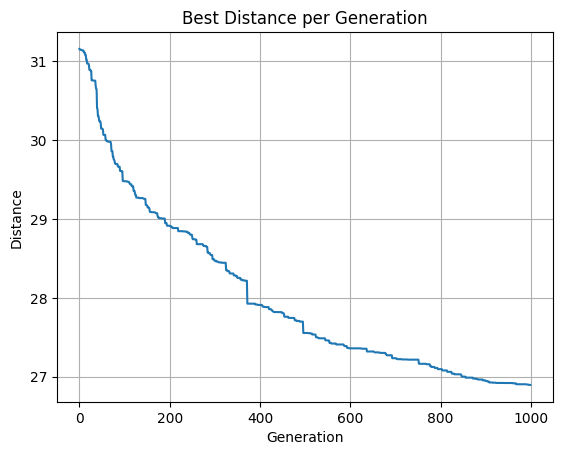

In [1]:
# -*- coding: utf-8 -*-
"""source_11.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1J-Cqm34bzzBV0AxaurIGp_N0SlALwkdj
"""

import numpy as np
import torch
import pandas as pd
import random
import csv
import matplotlib.pyplot as plt

#———————————————— 기본 작업 시작 ————————————————#

class TreeNode:
    def __init__(self, path, cost):
        self.path = path
        self.cost = cost
        self.children = []

device = torch.device("cpu")

def load_data(filepath): # csv 파일 읽어 도시 저장
    with open(filepath, mode='r', newline='') as file:
        data = [list(map(float, row)) for row in csv.reader(file)]
    tensor_data = torch.tensor(data, dtype=torch.float32).to(device)
    return tensor_data

def plot_path(path, coordinates):
    coordinates = coordinates.cpu().numpy()
    path = np.array(path + [path[0]])
    plt.plot(coordinates[path, 0], coordinates[path, 1], 'o-')
    plt.show()

#———————————————— 기본 작업 끝 ————————————————#


#———————————————— 0 세대 관련 작업 시작 ————————————————#
def MST(cities): # 괜찮은 population(0세대)를 만들기 위한 MST 알고리즘
    path = [0]  # 시작 노드를 0번 도시로 설정
    visited = set([0])
    current_city = 0
    while len(path) < len(cities):  # 모든 도시를 방문할 때까지
        next_city = None
        min_dist = np.inf
        for neighbor in range(len(cities)):
            if neighbor not in visited:
                dist = np.linalg.norm(cities[current_city] - cities[neighbor])
                if dist < min_dist:
                    min_dist = dist
                    next_city = neighbor
        path.append(next_city)
        visited.add(next_city)
        current_city = next_city

    # 마지막 경로를 0으로 설정
    path.append(0)
    # 경로의 길이 계산
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += np.linalg.norm(cities[path[i]] - cities[path[i+1]])
    total_distance += np.linalg.norm(cities[path[-1]] - cities[path[0]])  # 마지막 도시에서 출발 도시로의 거리 추가
    return path, len(visited), total_distance

def nearest_neighbor(cities): # 괜찮은 population(0세대)를 만들기 위한 nn 알고리즘
    num_cities = len(cities)
    unvisited_cities = set(range(1, num_cities))
    current_city = 0  # 시작 도시는 첫 번째 도시
    tour = [current_city]  # 경로의 시작은 시작 도시
    while unvisited_cities:
        nearest_city = min(unvisited_cities, key=lambda city: distance(cities[current_city], cities[city])) # 해당 노드에서 가장 가까운 도시 선택
        tour.append(nearest_city)
        unvisited_cities.remove(nearest_city)
        current_city = nearest_city
    tour.append(0)  # 출발 도시로 돌아가는 경로 추가
    return tour

def farthest_neighbor(cities): # Tree의 root노드를 최악에 가까운 경로로 선택하기 위해 nn 알고리즘의 반대
    num_cities = len(cities)
    unvisited_cities = set(range(1, num_cities))
    current_city = 0  # 시작 도시는 첫 번째 도시
    tour = [current_city]  # 경로의 시작은 시작 도시
    while unvisited_cities:
        farthest_city = max(unvisited_cities, key=lambda city: distance(cities[current_city], cities[city])) # 해당 노드에서 가장 먼 도시 선택
        tour.append(farthest_city)
        unvisited_cities.remove(farthest_city)
        current_city = farthest_city
    tour.append(0)  # 출발 도시로 돌아가는 경로 추가
    return tour

def expand_root_node(parent_node,base_node,how_many,coordinates,mutation_rate): # 0세대를 root 노드 아래에 생성
  for _ in range(how_many):
    new_path=mutate(base_node.path,mutation_rate) # base_node로 들어온 0세대 노드를 mutation하여 0세대 노드 추가 생성
    new_cost=calculate_cost(new_path,coordinates)
    new_node=TreeNode(new_path,new_cost)
    parent_node.children.append(new_node)

#———————————————— 0 세대 관력 작업 끝 ————————————————#


#———————————————— 기본 트리 작업 시작 ————————————————#

def distance(city1, city2): # 도시간 유클리드 거리 계산
    return np.linalg.norm(city1 - city2)

def calculate_cost(path, coordinates): # 하나의 경로의 비용 계산
    idx = torch.tensor(path + [path[0]], device=device)
    return torch.sum(torch.norm(coordinates[idx[:-1]] - coordinates[idx[1:]], dim=1)).item()

def stopping_condition(current_iteration, max_iterations):
    return current_iteration >= max_iterations

def expand_tree(node, num_expansions, coordinates, mutation_rate): # 트리 확장
    for _ in range(num_expansions):
        new_path = mutate(node.path, mutation_rate)
        new_cost = calculate_cost(new_path, coordinates)
        if new_cost>node.cost: # 자식이 부모보다 않 좋을 경우 트리 확장 X
          continue
        new_node = TreeNode(new_path, new_cost)
        node.children.append(new_node)

def find_best_leaf_node(node):
    if not node.children:
        return node
    else:
        leaf_nodes = []
        find_all_leaf_nodes(node, leaf_nodes)
        return min(leaf_nodes, key=lambda x: x.cost)

def find_all_leaf_nodes(node, leaf_nodes):
    if not node.children:
        leaf_nodes.append(node)
    else:
        for child in node.children:
            find_all_leaf_nodes(child, leaf_nodes)

#--------------------------------- 기본 트리 작업 끝 ---------------------------------#


#--------------------------------- 유전 알고리즘 시작 ---------------------------------#

def mutate(path, mutation_rate): # 유전 알고리즘의 mutation
    new_path = path[:]
    num_cities = len(path)

    # 첫 번째 도시와 마지막 도시를 제외한 나머지 도시에서 변이 수행
    for _ in range(int((num_cities - 2) * mutation_rate)):
        swap_idx1, swap_idx2 = random.sample(range(1, num_cities - 1), 2)  # 첫 번째 도시와 마지막 도시를 제외한 범위 내에서 랜덤 선택
        new_path[swap_idx1], new_path[swap_idx2] = new_path[swap_idx2], new_path[swap_idx1]

    return new_path

def genetic_algorithm(coordinates, max_iterations, num_expansions, mutation_rate,zero_genaration_num,zero_genaration_mutation_rate):
    root_path=farthest_neighbor(coordinates) # root 노드 패스 생성
    root_cost = calculate_cost(root_path, coordinates) # root 노드 패스의 cost 생성
    root = TreeNode(root_path, root_cost) # root 노드 생성

    # 0세대들 만들기 (nn ver)
    zero_generation_base_path=nearest_neighbor(coordinates)
    zero_generation_base_cost=calculate_cost(zero_generation_base_path,coordinates)
    zero_generation_base_node=TreeNode(zero_generation_base_path,zero_generation_base_cost) # 0 세대 base 노드
    expand_root_node(root,zero_generation_base_node,zero_genaration_num,coordinates,zero_genaration_mutation_rate)

    # 0세대들 만들기 (MST ver)
    MST_path,_,MST_cost=MST(coordinates)
    MST_node=TreeNode(MST_path,MST_cost) # 0 세대 base 노드
    expand_root_node(root,MST_node,zero_genaration_num,coordinates,zero_genaration_mutation_rate)

    # GA 돌리기
    current_iteration = 0
    best_costs = []
    while not stopping_condition(current_iteration, max_iterations):
        best_leaf_node = find_best_leaf_node(root)
        expand_tree(best_leaf_node, num_expansions, coordinates, mutation_rate)
        current_iteration += 1
        best_costs.append(best_leaf_node.cost)

    best_path = find_best_leaf_node(root).path
    best_cost = find_best_leaf_node(root).cost
    return best_cost, best_path, best_costs

#--------------------------------- 유전 알고리즘 끝 ---------------------------------#


#--------------------------------- main 함수 시작 ---------------------------------#

# Parameters
filepath = '2024_AI_TSP.csv'
max_iterations = 1000 # 세대수
num_expansions = 1000 # 하나의 노드를 확장할때, 즉, 자식을 만들때 얼마나 많은 자식을 만들 것인지
mutation_rate = 0.002 # GA를 돌릴때의 mutation rate
zero_genaration_num = 10 # zero_genaration_num 만큼의 MST 기반 0세대 수
zero_genaration_mutation_rate=0.005 # 0세대를 만들때 base_node 기준으로 얼마나 mutation 할 것인지의 비율

# Load data
data = load_data(filepath)

# Run genetic algorithm
best_cost, best_path, best_costs = genetic_algorithm(data, max_iterations, num_expansions, mutation_rate,zero_genaration_num,zero_genaration_mutation_rate)
print("경로 : ", best_path)
print("비용 : ", best_cost)

#———————————————— main 함수 끝 ————————————————#


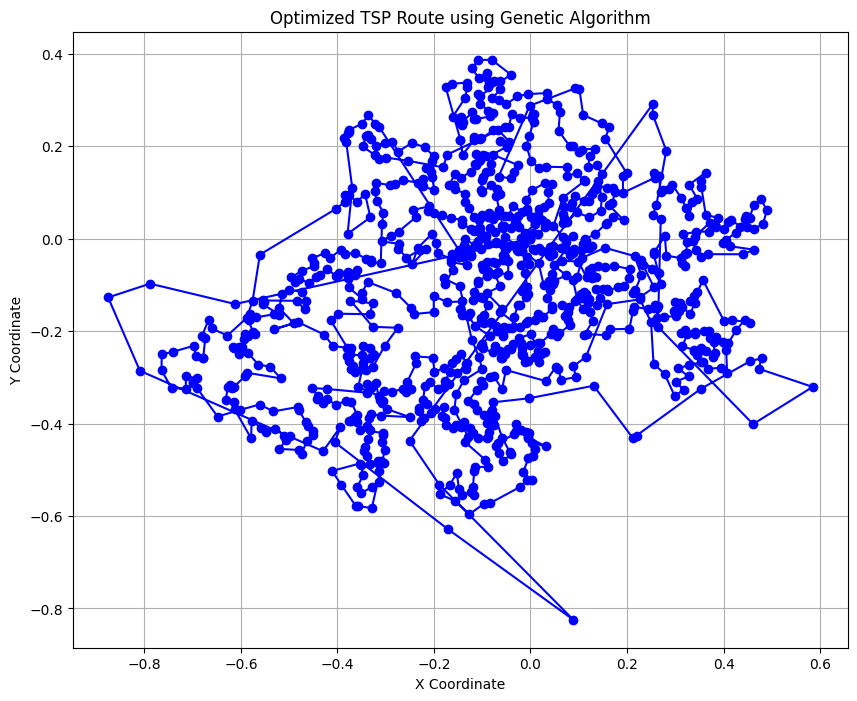

In [3]:
def plot_best_path(path, coordinates):
    # Extract coordinates for the best path
    route_coordinates = coordinates[path]

    # Add the starting city to the end to complete the loop
    route_coordinates = torch.vstack([route_coordinates, route_coordinates[0]])

    # Plot the optimized route
    plt.figure(figsize=(10, 8))
    plt.plot(route_coordinates[:, 0].cpu().numpy(), route_coordinates[:, 1].cpu().numpy(), marker='o', linestyle='-', color='b')
    plt.title("Optimized TSP Route using Genetic Algorithm")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()
plot_best_path(best_path,data)